In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import pandas as pd
import argparse
from scipy.integrate import solve_ivp
import pyBigWig as bw
import sys
sys.path.insert(0, '/home/jbreda/PROseq/scripts/FourierTransform')
from fourier_transform import fourier_transform
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
sys.path.insert(0, '/home/jbreda/PROseq/scripts/Phase_to_LabColor')
from phase_to_labcolor import phase_to_labcolor as p2lc

# Define the analytical solution of the ODE
def f_analytical_solution(Δt, x0, γ_k, k_μ, γ_l):
    a0, b0, k0, λ0 = x0

    # Calculate k(t), lambda(t), a(t) and b(t)
    k_t = np.exp(-γ_k*Δt) * (k0 - k_μ) + k_μ
    λ_t = np.exp(-γ_l*Δt) * λ0

    argument =  (k0 - k_t)/γ_k + k_μ * Δt
    factor = np.exp( (λ0-λ_t)/γ_l )

    a_t = factor * ( a0 * np.cos(argument) - b0 * np.sin(argument) )
    b_t = factor * ( b0 * np.cos(argument) + a0 * np.sin(argument) )
    
    return a_t, b_t, k_t, λ_t

# Define the Jacobian of the ODE
def F_jacobian(x, γ_k, γ_l):
    a, b, k, λ = x
    
    return np.array([
        [λ, -k, -b, a],
        [k, λ, a, b],
        [0, 0, -γ_k,0],
        [0, 0, 0, -γ_l]])

# Define measurement function: inverse fourier transform
def h(x,ω,T):
    H = np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0]), np.zeros(T.shape[0])]).T *2/T.shape[0]
    return H @ x

# Define the Jacobian of h
def H_jacobian(x,ω,T):
    return np.array([np.cos(ω*T), -np.sin(ω*T), np.zeros(T.shape[0]), np.zeros(T.shape[0])]).T *2/T.shape[0]

# P(t)' = F(t)P(t) + P(t)F(t)^T + Q
def dPdt(t,P,F,Q):
    P = P.reshape((4, 4))  # Reshape the 1D array P into a 3x3 matrix
    return (F @ P + P @ F.T + Q).flatten() # Flatten the 3x3 matrix to a 1D array of size 9

# get expression per bin in a given region
def get_data(coord, bw_folder, bin_size):

    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}

    [chr,start,end,strand] = coord.split(':')

    # get data from bigWigs
    df = pd.DataFrame(columns=['start','end'])
    for t in T:
        sample = f'CT{t:02d}'
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        bw_file = bw.open(fin)
        df_t = pd.DataFrame(bw_file.intervals(chr,int(start),int(end)),columns=['start','end',f"{t}"])
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df.sort_values('start',inplace=True)
    df.reset_index(inplace=True,drop=True)

    # replace start and end with position in the middle of the bin, and set as index
    start = df.start.values
    end = df.end.values
    df['start'] = ( (df.start.values + df.end.values)/2 ).astype(int) # bp
    df.drop('end',axis=1,inplace=True)
    df.columns = ['pos'] + df.columns[1:].tolist()
    df.set_index('pos',inplace=True)

    # fill missing values with 0, add pseudo count, log2 transform
    df = df.infer_objects(copy=False)
    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log2(x+1),axis=1)
    
    return df, start, end

# get extended kalman filter parameters
def get_kf_parameters(bin_size):

    params = {}
    
    # Parameters
    T = np.arange(0,48,4) # time points
    P = 24 # period
    ω = 2*np.pi/P # angular frequency [rad/h]
    m = len(T) # number of time points
    n = 4 # number of hidden states
    dx = bin_size*1e-3 # distance between positions [kb]
    v_mean = 34 # [bp/s]
    #k_mean = (ω/3600)/v_mean # [rad/bp]
    k_mean = -(ω/3600)/(v_mean/1e3) # [rad/kb]
    # minus sign because the rotation is defined clockwise whereas the positive sign is in the trigonometric direction

    # dynamics of the process z(t) = a(t) + ib(t)
    sigma_z = 1e-3 # variance the process ( z(x) = a(x) + ib(x) ) [kb]

    # rate of mean reversion of k(t)
    gamma_k = 1/10 # return from k(t) to k_mu in 1/gamma_k =~ 10 [kb]
    # mean of k(t) [rad/kb]
    k_mu = k_mean
    # variance k(t) process
    sigma_k = 2*k_mu # variance k(t) process of the same order of magnitude as the signal
    eps_k = sigma_k * np.sqrt(2*gamma_k)

    # rate of mean reversion of λ(t)
    gamma_l = 1/2 # 1 in 2kb. make it soft, if too rigid, the system will be very unstable because lambda can stay positive for a long time 
    # variance λ(t) process
    sigma_l = np.log(2)/10 # allow for about 2 fold in 10kb
    eps_l = sigma_l * np.sqrt(2*gamma_l)

    params['T'] = T
    params['ω'] = ω
    params['m'] = m
    params['n'] = n
    params['dx'] = dx
    params['v_mean'] = v_mean
    params['k_mean'] = k_mean
    params['sigma_z'] = sigma_z
    params['gamma_k'] = gamma_k
    params['k_mu'] = k_mu
    params['sigma_k'] = sigma_k
    params['eps_k'] = eps_k
    params['gamma_l'] = gamma_l
    params['sigma_l'] = sigma_l
    params['eps_l'] = eps_l

    return params

def extended_kalman(bw_folder, bin_size, Noise_params, kf_parameters, coord):

    # get parameters
    T = kf_parameters['T']
    ω = kf_parameters['ω']
    m = kf_parameters['m']
    n = kf_parameters['n']
    dx = kf_parameters['dx']
    sigma_z = kf_parameters['sigma_z']
    gamma_k = kf_parameters['gamma_k']
    k_mu = kf_parameters['k_mu']
    sigma_k = kf_parameters['sigma_k']
    eps_k = kf_parameters['eps_k']
    gamma_l = kf_parameters['gamma_l']
    sigma_l = kf_parameters['sigma_l']
    eps_l = kf_parameters['eps_l']

    # Process noise covariance matrix
    Q = np.eye(n)*(sigma_z)**2
    #Q[2,2] = sigma_k**2  # Variance of k(t)
    #Q[3,3] = sigma_l**2  # Variance of λ(t)
    Q[2,2] = eps_k*eps_k # Variance of k(t)
    Q[3,3] = eps_l*eps_l  # Variance of λ(t)

    # get data
    [chr,start,end,strand] = coord.split(':')
    df,starts,ends = get_data(coord,bw_folder,bin_size)
    positions = df.index*1e-3 # positions [kb]
    measurments = df.values.T # time x position
    del df
    # flip if strand is '-'
    if strand == '-':
        measurments = measurments[:,::-1]
        positions = -positions[::-1]
    X = measurments - np.mean(measurments,axis=0,keepdims=True)
    N_bins = X.shape[1]

    if N_bins == 0:
        return None

    # fourier transform bin by bin
    f_n = np.sum(X.T*np.exp(-1j*ω*T),1)
    φ_n, a_n, R2, pval, μ = fourier_transform(measurments,T,ω)
    φ_n[pval>0.1] = np.nan
    #f_n[R2<0.1] = np.nan

    # Use unnormalized expression at each position for R
    R = np.zeros((N_bins,m,m))
    # exponential decay of R as a function of z :  R(x) = a * exp(-b * x) + c
    for i in range(N_bins):
        if np.isnan(measurments[:,i]).all():
            continue
        r_i = Noise_params['a'] * np.exp(-Noise_params['b'] * R2[i]*measurments[:,i] ) + Noise_params['c']
        r_i[measurments[:,i] < Noise_params['m_err_max']] = Noise_params['err_max']
        R[i,:,:] = np.diag(r_i)
    #R *= 1

    # EKF implementation
    # Initial state estimate and covariance
    f0 = np.nanmean(f_n[:5]*R2[:5])/np.nanmean(R2[:5])
    a0 = f0.real
    b0 = f0.imag
    k0 = k_mu
    λ0 = 0
    x0 = np.array([a0,b0,k0,λ0])

    x_pred = np.zeros((N_bins,x0.shape[0]))
    x_est = np.zeros((N_bins,x0.shape[0]))

    P0 = np.diag([sigma_z, sigma_z, sigma_k, sigma_l]).flatten()  # Initial state covariance (4x4)-matrix -> (16)-vector
    P_pred = np.zeros((N_bins,P0.shape[0]))
    P_est = np.zeros((N_bins,P0.shape[0]))

    LL = np.zeros(N_bins) # Log likelihood

    # Forward filter
    for k in range(N_bins):
        dx = positions[k] - positions[k-1]
        # Predict
        if k == 0:
            x_pred[k] = x0
            P_pred[k] = P0
        else:
            x_pred[k] = f_analytical_solution(dx, x_est[k-1], gamma_k, k_mu, gamma_l)
            F = F_jacobian(x_pred[k-1], gamma_k, gamma_l)
            solP = solve_ivp(dPdt, [positions[k-1], positions[k]], P_est[k-1], args=(F,Q*dx,))
            P_pred[k] = solP.y[:, -1]
        
        # Update
        H = H_jacobian(x_pred[k],ω,T)
        S = np.linalg.multi_dot([H,P_pred[k].reshape((n,n)),H.T]) + R[k]
        if np.linalg.det(S) == 0:
            print('Singular matrix')
            print(coord)
            break
        if np.linalg.det(S) < 0:
            print('Negative determinant')
            print(coord)
            break
        K = np.linalg.multi_dot([P_pred[k].reshape((n,n)), H.T, np.linalg.inv(S)])
        res = X[:, k] - h(x_pred[k],ω,T)
        x_est[k] = x_pred[k] + K @ (res)
        P_est[k] = ( (np.eye(n) - K @ H) @ P_pred[k].reshape((n,n)) ).flatten()
        
        # Log likelihood
        LL[k] = -0.5 * ( np.linalg.multi_dot([res.T, np.linalg.inv(S), res]) + np.log(np.linalg.det(S)) + m * np.log(2*np.pi) )

    # Backward smoother
    x_smooth = np.zeros((N_bins,x0.shape[0]))
    P_smooth = np.zeros((N_bins,P0.shape[0]))
    x_smooth[-1] = x_est[-1]
    P_smooth[-1] = P_est[-1]
    for k in range(N_bins-2,-1,-1):
        F = F_jacobian(x_est[k], gamma_k, gamma_l)
        J = np.linalg.multi_dot([P_est[k].reshape((n,n)), F.T, np.linalg.inv(P_pred[k+1].reshape((n,n)))])
        x_smooth[k] = x_est[k] + J @ (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = ( P_est[k].reshape((n,n)) + J @ (P_smooth[k+1].reshape((n,n)) - P_pred[k+1].reshape((n,n))) @ J.T ).flatten()

    #z_est = h(x_est.T,ω,T)
    #P_est = P_est.reshape((N_bins,n,n))
    #z_smooth = h(x_smooth.T,ω,T)
    #P_smooth = P_smooth.reshape((N_bins,n,n))

    # Amp and phase of kalman filter
    #a = x_smooth[:,0]
    #b = x_smooth[:,1]
    #amp = 4/m * np.abs(a + 1j*b)
    #φ_kf = -np.arctan2(b,a)
    #φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    # reflip if strand is '-'
    if strand == '-':
        x_smooth = x_smooth[::-1]
        LL = LL[::-1]

    # Save results in a dataframe
    df = pd.DataFrame(columns=['chr','start','end','strand','a','b','k','λ','LL'])

    df.start = starts
    df.end = ends
    df.chr = chr
    df.strand = strand
    df.loc[:,['a','b','k','λ']] = x_smooth
    df.LL = LL

    return df

def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

chr1:67900000:69200000:-
Forward filter


/tmp/ipykernel_2901901/3631449563.py:210: RuntimeWarning: invalid value encountered in sqrt
  σ_amp = 4/m * np.sqrt( σ2_a + σ2_b + 2*σ_ab )
/tmp/ipykernel_2901901/3631449563.py:220: RuntimeWarning: invalid value encountered in sqrt
  σ_φ = np.sqrt( b*b*σ2_a + a*a*σ2_b - 2*a*b*σ_ab )/(a*a+b*b)
/tmp/ipykernel_2901901/3631449563.py:236: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(positions,k,yerr=np.sqrt(σ2_k),fmt='.')
/tmp/ipykernel_2901901/3631449563.py:255: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(positions,a,yerr=np.sqrt(σ2_a),fmt='.')


chr3:61977000:62958000:+
Forward filter


/tmp/ipykernel_2901901/3631449563.py:220: RuntimeWarning: invalid value encountered in sqrt
  σ_φ = np.sqrt( b*b*σ2_a + a*a*σ2_b - 2*a*b*σ_ab )/(a*a+b*b)
/tmp/ipykernel_2901901/3631449563.py:236: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(positions,k,yerr=np.sqrt(σ2_k),fmt='.')
/tmp/ipykernel_2901901/3631449563.py:264: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(positions,b,yerr=np.sqrt(σ2_b),fmt='.')


<Figure size 3000x100 with 0 Axes>

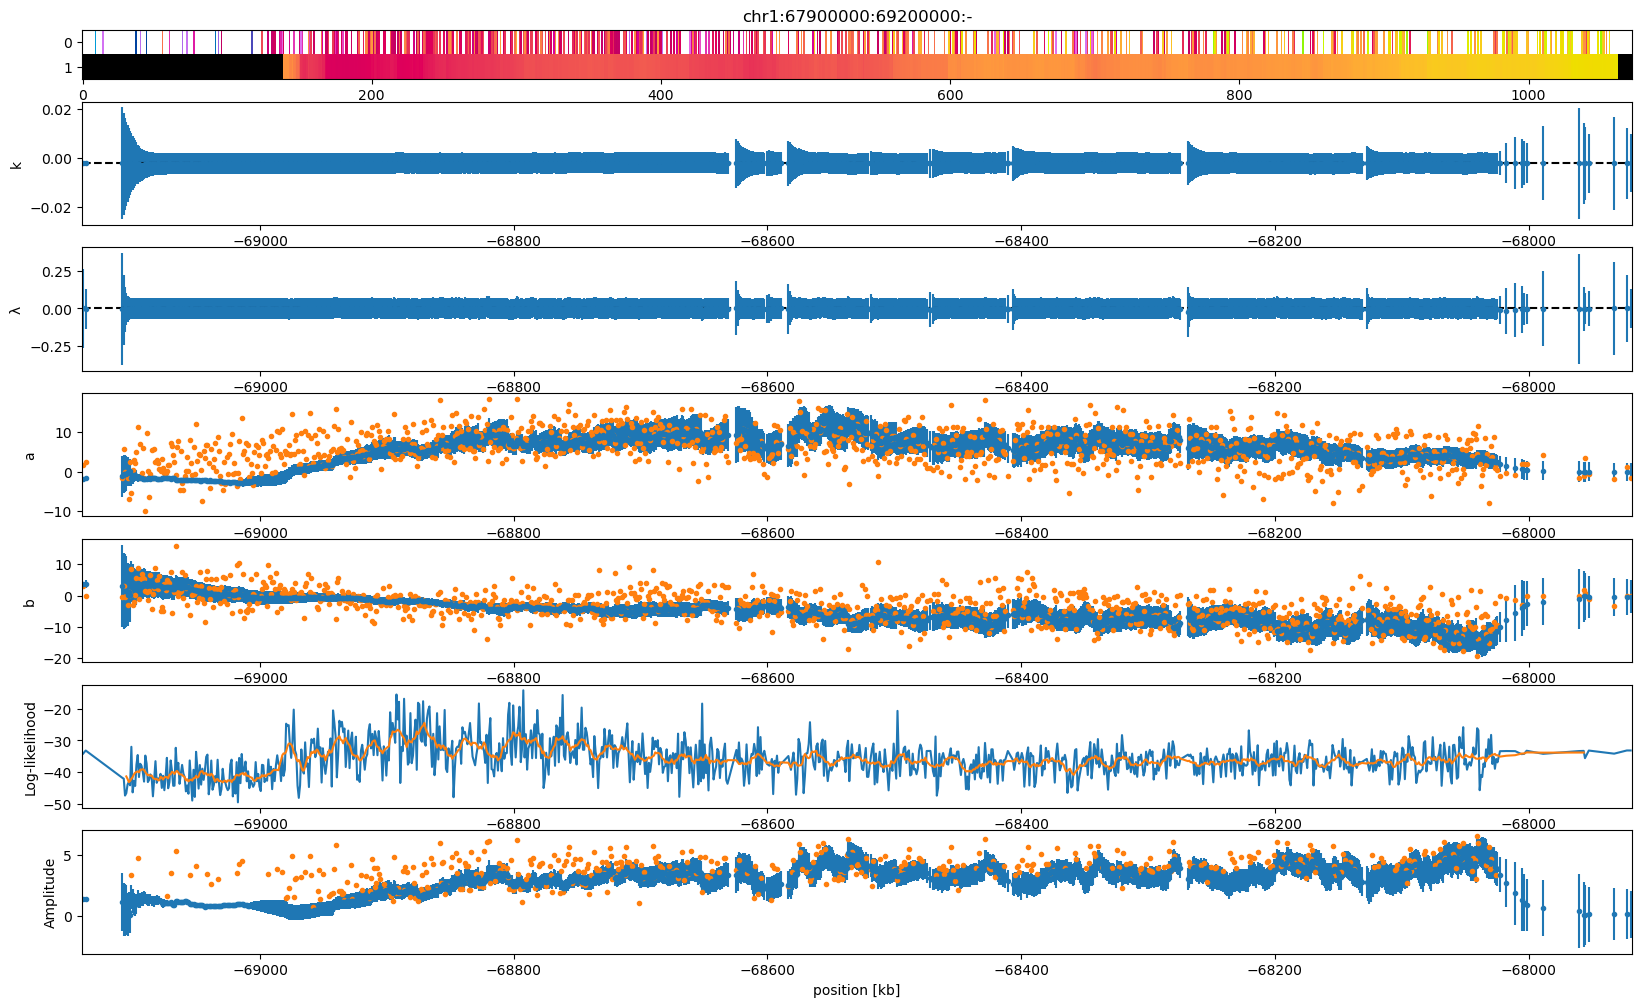

<Figure size 3000x100 with 0 Axes>

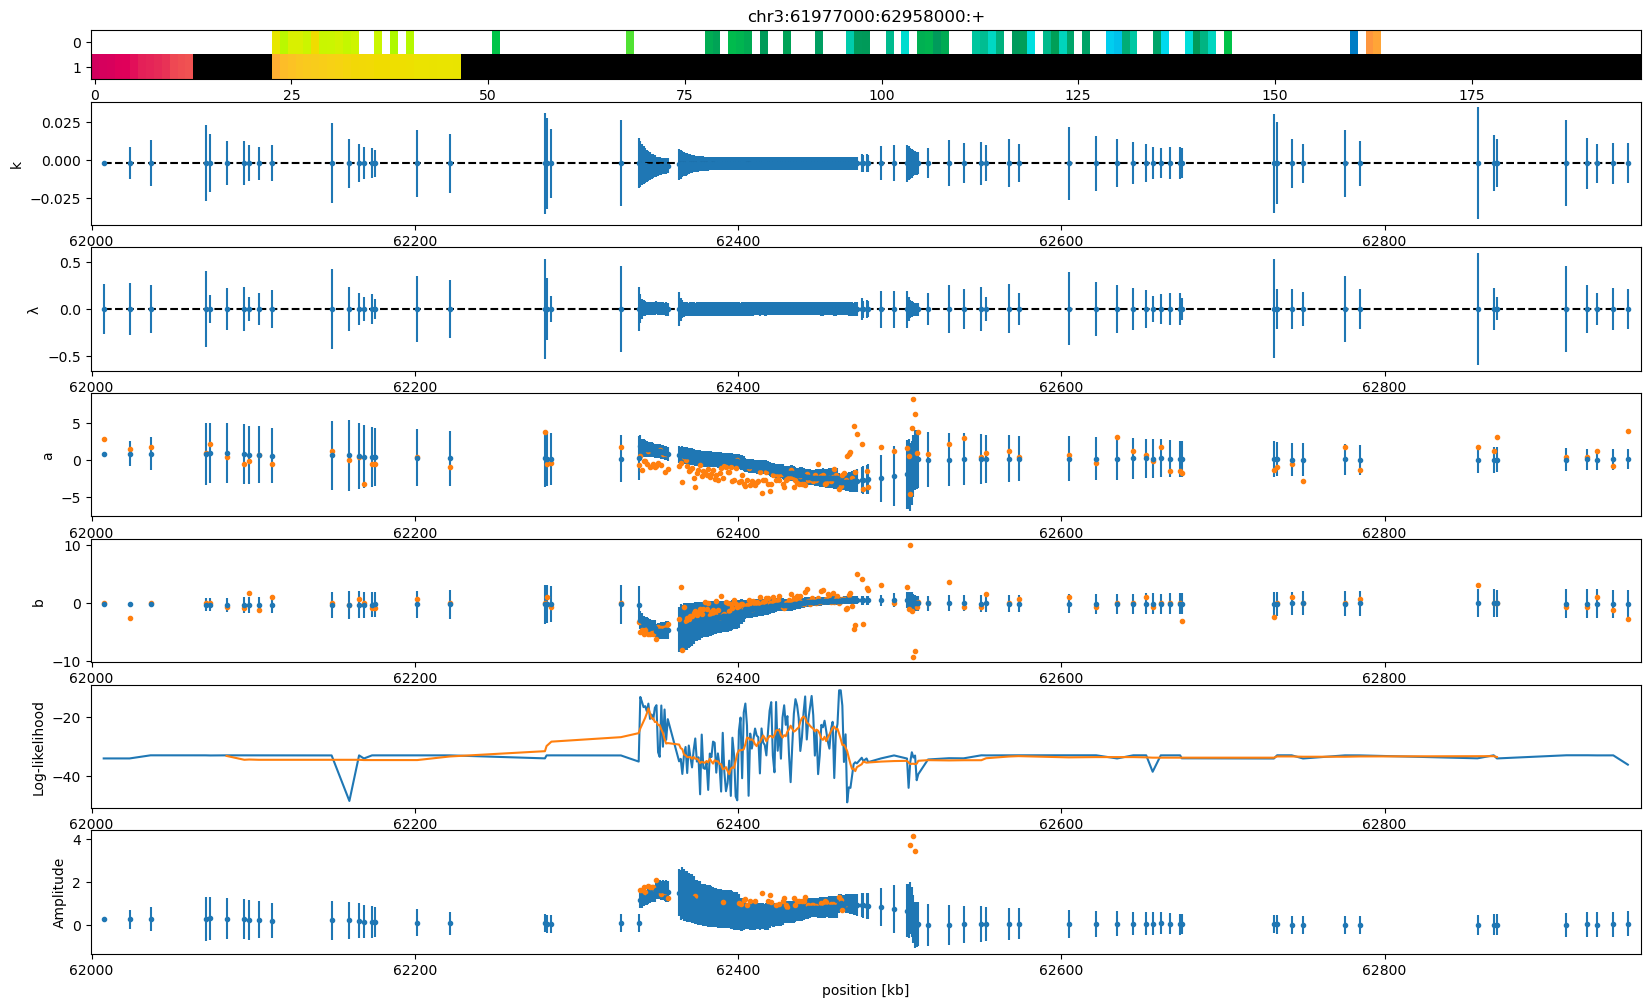

In [20]:
#args = parse_args()
bin_size = 1000
noise_model = f"../results/GRCm38/binned_norm_coverage/Noise_model_parameters_{bin_size}bp.csv"
bw_folder = '../results/GRCm38/binned_norm_coverage'
out_table = 'tmp.csv'
#
## get expressed regions from bed file
#expressed_regions = pd.read_csv(args.expressed_regions,sep='\t',header=None)
#expressed_regions.columns = ['chr','start','end']

# get noise model parameters

fin = open(noise_model,'r')
lines = fin.readlines()
Noise_params = {}
for line in lines:
    if line[0] == '#':
        continue
    line = line.strip().split('\t')
    Noise_params[line[0]] = float(line[1])
fin.close()

# get kalman filter model parameters
kf_parameters = get_kf_parameters(bin_size)


# get coordinates list
#COORD = []
#for idx_region in expressed_regions.index:
#    [chr,start,end] = expressed_regions.loc[idx_region,['chr','start','end']]
#    for strand in ['+','-']:
#        coord = f'{chr}:{start}:{end}:{strand}'
#        COORD.append(coord)
COORD = ['chr6:3551000:7059000:-','chr17:62261000:68305000:-','chr18:43979000:47740000:+','chr17:34850000:35150000:-','chr17:26500000:26800000:+','chr7:19650855:19880000:-','chr1:67900000:69200000:-','chr3:61977000:62958000:+']
# run Kalman filter
OUT = []
for coord in COORD[-2:]:
    print(coord)
        
    # get parameters
    T = kf_parameters['T']
    ω = kf_parameters['ω']
    m = kf_parameters['m']
    n = kf_parameters['n']
    dx = kf_parameters['dx']
    sigma_z = kf_parameters['sigma_z']
    gamma_k = kf_parameters['gamma_k']
    k_mu = kf_parameters['k_mu']
    sigma_k = kf_parameters['sigma_k']
    eps_k = kf_parameters['eps_k']
    gamma_l = kf_parameters['gamma_l']
    sigma_l = kf_parameters['sigma_l']
    eps_l = kf_parameters['eps_l']

    # Process noise covariance matrix
    Q = np.eye(n)*(sigma_z)**2
    #Q[2,2] = sigma_k**2  # Variance of k(t)
    #Q[3,3] = sigma_l**2  # Variance of λ(t)
    Q[2,2] = eps_k*eps_k # Variance of k(t)
    Q[3,3] = eps_l*eps_l  # Variance of λ(t)

    # get data
    [chr,start,end,strand] = coord.split(':')
    df,starts,ends = get_data(coord,bw_folder,bin_size)
    positions = df.index*1e-3 # positions [kb]
    measurments = df.values.T # time x position
    del df
    # flip if strand is '-'
    if strand == '-':
        measurments = measurments[:,::-1]
        positions = -positions[::-1]
    X = measurments - np.mean(measurments,axis=0,keepdims=True)
    N_bins = X.shape[1]

    if N_bins == 0:
        df = None
        break

    # fourier transform bin by bin
    f_n = np.sum(X.T*np.exp(-1j*ω*T),1)
    φ_n, a_n, R2, pval, μ = fourier_transform(measurments,T,ω)
    φ_n[pval>0.1] = np.nan
    a_n[pval>0.1] = np.nan
    #f_n[R2<0.1] = np.nan

    # Use unnormalized expression at each position for R
    R = np.zeros((N_bins,m,m))
    # exponential decay of R as a function of z :  R(x) = a * exp(-b * x) + c
    for i in range(N_bins):
        if np.isnan(measurments[:,i]).all():
            continue
        r_i = Noise_params['a'] * np.exp(-Noise_params['b'] * R2[i]*measurments[:,i] ) + Noise_params['c']
        r_i[measurments[:,i] < Noise_params['m_err_max']] = Noise_params['err_max']
        R[i,:,:] = np.diag(r_i)
    R *= 2

    # EKF implementation
    # Initial state estimate and covariance
    f0 = np.nanmean(f_n[:10]*R2[:10])/np.nanmean(R2[:10])
    a0 = f0.real
    b0 = f0.imag
    k0 = k_mu
    λ0 = 0
    x0 = np.array([a0,b0,k0,λ0])

    x_pred = np.zeros((N_bins,x0.shape[0]))
    x_est = np.zeros((N_bins,x0.shape[0]))

    P0 = np.diag([sigma_z, sigma_z, sigma_k, sigma_l]).flatten()  # Initial state covariance (4x4)-matrix -> (16)-vector
    P_pred = np.zeros((N_bins,P0.shape[0]))
    P_est = np.zeros((N_bins,P0.shape[0]))

    LL = np.zeros(N_bins) # Log likelihood

    # Forward filter
    print('Forward filter')
    for k in range(N_bins):
        dx = positions[k] - positions[k-1]
        # Predict
        if k == 0:
            x_pred[k] = x0
            P_pred[k] = P0
        else:
            x_pred[k] = f_analytical_solution(dx, x_est[k-1], gamma_k, k_mu, gamma_l)
            F = F_jacobian(x_pred[k-1], gamma_k, gamma_l)
            solP = solve_ivp(dPdt, [positions[k-1], positions[k]], P_est[k-1], args=(F,Q*dx,))
            P_pred[k] = solP.y[:, -1]
        
        # Update
        H = H_jacobian(x_pred[k],ω,T)
        S = np.linalg.multi_dot([H,P_pred[k].reshape((n,n)),H.T]) + R[k]
        if not is_invertible(S):
            K = np.zeros((n,m))
        else:
            K = np.linalg.multi_dot([P_pred[k].reshape((n,n)), H.T, np.linalg.inv(S)])
        res = X[:, k] - h(x_pred[k],ω,T)
        x_est[k] = x_pred[k] + K @ (res)
        P_est[k] = ( (np.eye(n) - K @ H) @ P_pred[k].reshape((n,n)) ).flatten()
        
        # Log likelihood
        if not is_invertible(S):
            LL[k] = np.nan
        else:
            LL[k] = -0.5 * ( np.linalg.multi_dot([res.T, np.linalg.inv(S), res]) + np.log(np.linalg.det(S)) + m * np.log(2*np.pi) )

    # Backward smoother
    #print('Backward smoother')
    #x_smooth = np.zeros((N_bins,x0.shape[0]))
    #P_smooth = np.zeros((N_bins,P0.shape[0]))
    #x_smooth[-1] = x_est[-1]
    #P_smooth[-1] = P_est[-1]
    #LL_bs = np.zeros(N_bins) # Log likelihood of the backward smoother
    #for k in range(N_bins-2,-1,-1):
    #    F = F_jacobian(x_est[k], gamma_k, gamma_l)
    #    if not is_invertible(P_pred[k+1].reshape((n,n))):
    #        print(k,coord)
    #        J = np.zeros((n,n))
    #    else:
    #        J = np.linalg.multi_dot([P_est[k].reshape((n,n)), F.T, np.linalg.inv(P_pred[k+1].reshape((n,n)))])
    #    x_smooth[k] = x_est[k] + J @ (x_smooth[k+1] - x_pred[k+1])
    #    P_smooth[k] = ( P_est[k].reshape((n,n)) + J @ (P_smooth[k+1].reshape((n,n)) - P_pred[k+1].reshape((n,n))) @ J.T ).flatten()
    #
    #    
    #    # Log likelihood of the backward smoother
    #    if not is_invertible(P_pred[k+1].reshape((n,n))):
    #        LL_bs[k] = np.nan
    #    else:
    #        LL_bs[k] = -0.5 * ( np.linalg.multi_dot([res.T, np.linalg.inv(S), res]) + np.log(np.linalg.det(S)) + m * np.log(2*np.pi) )

    # reflip if strand is '-'
    #if strand == '-':
        #x_est = x_est[::-1]
        #LL = LL[::-1]
        #x_smooth = x_smooth[::-1]
        #LL_bs = LL_bs[::-1]

    # Save results in a dataframe
    df = pd.DataFrame(columns=['chr','start','end','strand','a','b','k','λ','LL'])

    df.start = starts
    df.end = ends
    df.chr = chr
    df.strand = strand
    df.loc[:,['a','b','k','λ']] = x_est
    df.LL = LL

    OUT.append( df )


    # Plot results

    #μ_smooth = x_smooth[:,0] + 1j*x_smooth[:,1]
    #a_smooth = 4/m * np.abs(μ_smooth)
    #φ_smooth = -np.arctan2(x_smooth[:,1],x_smooth[:,0])
    #φ_smooth[φ_smooth<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
    #k_smooth = x_smooth[:,2]
    #λ_smooth = x_smooth[:,3]

    a = x_est[:,0]
    b = x_est[:,1]
    k = x_est[:,2]
    λ = x_est[:,3]
    σ2_a = P_est.reshape((N_bins,n,n))[:,0,0]
    σ2_b = P_est.reshape((N_bins,n,n))[:,1,1]
    σ_ab = P_est.reshape((N_bins,n,n))[:,0,1]
    σ2_k = P_est.reshape((N_bins,n,n))[:,2,2]
    σ2_λ = P_est.reshape((N_bins,n,n))[:,3,3]
    μ = a + 1j*b
    amp = 4/m * np.abs(μ)
    σ_amp = 4/m * np.sqrt( σ2_a + σ2_b + 2*σ_ab )

    φ = -np.arctan2(b,a)
    φ[φ<0] += 2*np.pi
    # f = -artan(b/a)
    # σ_f(a,b) = |df/da|^2 σ_a^2 + |df/da|^2 σ_b^2 + 2 df/da df/db σ_ab
    # df/da = b/(a^2+b^2)
    # df/db = -a/(a^2+b^2)
    # σ2_f = (b/(a^2+b^2))^2 σ_a^2 + (-a/(a^2+b^2))^2 σ_b^2 - (ab/(a^2+b^2)) σ_ab
    # σ_f = sqrt( b^2 σ_a^2 + a^2 σ_b^2 - 2ab σ_ab )/(a^2+b^2)^2
    σ_φ = np.sqrt( b*b*σ2_a + a*a*σ2_b - 2*a*b*σ_ab )/(a*a+b*b)


    #df_out.to_csv(out_table,index=False,sep='\t')
    Φ = np.ones((2,len(positions),3))
    Φ[0,:] = p2lc(φ=φ_n,amp=a_n)
    Φ[1,:] = p2lc(φ=φ,amp=a)

    fig = plt.figure(figsize=(30,1))
    fig, axes = plt.subplots(7, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [2, 5, 5, 5, 5, 5, 5]})

    ax = axes[0]
    ax.set_title(coord)
    ax.imshow(Φ,aspect='auto',interpolation='none')

    ax = axes[1]
    ax.errorbar(positions,k,yerr=np.sqrt(σ2_k),fmt='.')
    #ax.plot(positions,k_smooth)
    ax.plot([positions[0],positions[-1]],[k_mu,k_mu],'k--')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('k')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])

    ax = axes[2]
    ax.errorbar(positions,λ,yerr=np.sqrt(σ2_λ),fmt='.')
    #ax.plot(positions,λ_smooth)
    ax.plot([positions[0],positions[-1]],[0,0],'k--')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('λ')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])
    #fig.savefig(fname[0],bbox_inches='tight')

    ax = axes[3]
    ax.errorbar(positions,a,yerr=np.sqrt(σ2_a),fmt='.')
    #ax.plot(positions,x_smooth[:,0])
    ax.plot(positions,f_n.real,'.')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('a')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])
    
    ax = axes[4]
    ax.errorbar(positions,b,yerr=np.sqrt(σ2_b),fmt='.')
    #ax.plot(positions,x_smooth[:,1])
    ax.plot(positions,f_n.imag,'.')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('b')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])

    ax = axes[5]
    ax.plot(positions,LL)
    #ax.plot(positions,LL_bs)
    # moving average of LL
    # add nan padding at the beginning and end of LL_ma
    avg_win = 11
    LL_ma = np.convolve(LL, np.ones(avg_win)/avg_win, mode='valid')
    pad = np.zeros(avg_win//2)*np.nan
    LL_ma = np.concatenate([pad,LL_ma,pad])
    
    ax.plot(positions,LL_ma)
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('Log-likelihood')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])

    ax = axes[6]
    ax.errorbar(positions,amp,yerr=σ_amp,fmt='.')
    #ax.plot(positions,a_smooth)
    ax.plot(positions,a_n,'.')
    ax.set_xlabel('position [kb]')
    ax.set_ylabel('Amplitude')
    dx = positions[1] - positions[0]
    ax.set_xlim([positions[0]-dx/2,positions[-1]+dx/2])



df_out = OUT[0]
for df in OUT[1:]:
    if df is not None:
        df_out = pd.concat([df_out,df],ignore_index=True,axis=0)


In [25]:
P_est.reshape((N_bins,n,n))[:3][::-1]

array([[[ 9.99996378e-04,  1.65930278e-24,  0.00000000e+00,
          0.00000000e+00],
        [ 1.53364505e-24,  9.99995750e-04,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -4.27776777e-03,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          6.93147181e-02]],

       [[ 2.94316432e+00, -5.36504976e-01, -7.53858774e-04,
          1.27134268e-01],
        [-5.36504976e-01, -8.17435657e-02, -4.19740888e-03,
         -2.01547387e-02],
        [-7.53858774e-04, -4.19740888e-03,  1.06369239e-04,
          2.15234266e-07],
        [ 1.27134268e-01, -2.01547387e-02,  2.15234266e-07,
          7.67842016e-02]],

       [[ 5.14376032e+00, -1.08253068e+00,  7.42412409e-06,
          1.01647946e-01],
        [-1.08253068e+00,  6.70991508e-03,  8.39784927e-05,
         -1.97008766e-02],
        [ 7.42412409e-06,  8.39784927e-05,  2.28121486e-04,
          4.03506941e-09],
        [ 1.01647946e-01, -1.97008766e-

In [26]:
P_est.reshape((N_bins,n,n))[:3][::-1]

array([[[ 5.14376032e+00, -1.08253068e+00,  7.42412409e-06,
          1.01647946e-01],
        [-1.08253068e+00,  6.70991508e-03,  8.39784927e-05,
         -1.97008766e-02],
        [ 7.42412409e-06,  8.39784927e-05,  2.28121486e-04,
          4.03506941e-09],
        [ 1.01647946e-01, -1.97008766e-02,  4.03506941e-09,
          6.24189719e-02]],

       [[ 2.94316432e+00, -5.36504976e-01, -7.53858774e-04,
          1.27134268e-01],
        [-5.36504976e-01, -8.17435657e-02, -4.19740888e-03,
         -2.01547387e-02],
        [-7.53858774e-04, -4.19740888e-03,  1.06369239e-04,
          2.15234266e-07],
        [ 1.27134268e-01, -2.01547387e-02,  2.15234266e-07,
          7.67842016e-02]],

       [[ 9.99996378e-04,  1.65930278e-24,  0.00000000e+00,
          0.00000000e+00],
        [ 1.53364505e-24,  9.99995750e-04,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -4.27776777e-03,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+